# Scaling, Normalisation, and Discretisation in Python

---

## Scenario and learning goals

*Business scenario:* You are preparing customer data for a small online electronics shop.  
Columns include `Age`, `AnnualIncome`, and `BasketValue`. The data will feed simple models and dashboards.  

Your goals:
1. Understand why scaling matters and when to use normalisation vs standardisation.
2. Apply Min–Max normalisation and z-score standardisation.
3. Apply robust median–IQR scaling when there are outliers.
4. Discretise a continuous variable using equal-width, equal-frequency, and domain-driven binning.
5. Reflect on how binning choices affect downstream analysis.

This matches the topics in the slides: scaling, normalisation, standardisation, robust scaling, and discretisation. 


In [ ]:
# Setup
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.float_format", lambda v: f"{v:.3f}")

# Sample data: customers of an online shop
rng = np.random.default_rng(42)
n = 24

df = pd.DataFrame({
    "CustomerID": np.arange(1, n+1),
    "Age": rng.integers(19, 70, size=n),
    "AnnualIncome": rng.normal(38000, 9000, size=n).round(0).astype(int),
    "BasketValue": rng.normal(85, 25, size=n).round(1)
})

# Add a couple of outliers
df.loc[[2, 17], "AnnualIncome"] = [120000, 145000]      # unusually high incomes
df.loc[[5], "BasketValue"] = 420.0                      # a very high basket
df.head()

,CustomerID,Age,AnnualIncome,BasketValue
0,1,23,38594,82.200
1,2,58,48145,64.000
2,3,52,120000,64.400
3,4,41,30266,101.300
4,5,41,41319,103.600


## Why scaling is important

Many algorithms compare feature values directly. If one feature has much larger numbers it can dominate the analysis.  
Example: `Age` is between 19 and 70, `AnnualIncome` is between about 20,000 and 150,000. Without scaling, `AnnualIncome` can overwhelm distance-based methods or change optimisation behaviour.  
Slides highlight magnitude independence and consistency between train and test sets as motivations for scaling. 


In [2]:
# Inspect raw ranges to see why scaling is needed
df[["Age", "AnnualIncome", "BasketValue"]].agg(["min", "max", "mean", "std"])

,Age,AnnualIncome,BasketValue
min,23.000,29370.000,48.600
max,68.000,145000.000,420.000
mean,45.542,47172.083,99.712
std,14.563,27421.680,70.478


## Min–Max normalisation (to [0, 1])

Normalisation rescales each feature to a fixed range, commonly [0, 1], while preserving relative positions:  

x' = (x − min) / (max − min)

Use normalisation when you need values on the same bounded scale. 


In [3]:
# Min–Max normalisation with scikit-learn
minmax = MinMaxScaler(feature_range=(0, 1))
cols = ["Age", "AnnualIncome", "BasketValue"]
df_minmax = pd.DataFrame(minmax.fit_transform(df[cols]), columns=[c + "_minmax" for c in cols])
pd.concat([df[cols].head(8), df_minmax.head(8)], axis=1)


,Age,AnnualIncome,BasketValue,Age_minmax,AnnualIncome_minmax,BasketValue_minmax
0,23,38594,82.200,0.000,0.080,0.090
1,58,48145,64.000,0.778,0.162,0.041
2,52,120000,64.400,0.644,0.784,0.043
3,41,30266,101.300,0.400,0.008,0.142
4,41,41319,103.600,0.400,0.103,0.148
5,62,29370,420.000,0.867,0.000,1.000
6,23,45906,68.400,0.000,0.143,0.053
7,54,37551,90.800,0.689,0.071,0.114


## Standardisation (z-scores)

Standardisation centres each feature at 0 and rescales so the standard deviation is 1:  

z = (x − μ) / σ

Use standardisation when algorithms assume normally distributed features or use distance measures. 


In [4]:
# Z-score standardisation
standard = StandardScaler()

df_std = pd.DataFrame(standard.fit_transform(df[cols]), columns=[c + "_std" for c in cols])
pd.concat([df[cols].head(8), df_std.head(8)], axis=1)


,Age,AnnualIncome,BasketValue,Age_std,AnnualIncome_std,BasketValue_std
0,23,38594,82.200,-1.581,-0.320,-0.254
1,58,48145,64.000,0.874,0.036,-0.518
2,52,120000,64.400,0.453,2.713,-0.512
3,41,30266,101.300,-0.319,-0.630,0.023
4,41,41319,103.600,-0.319,-0.218,0.056
5,62,29370,420.000,1.154,-0.663,4.642
6,23,45906,68.400,-1.581,-0.047,-0.454
7,54,37551,90.800,0.593,-0.358,-0.129


## Robust median–IQR scaling

Robust scaling replaces the mean with the median and replaces the standard deviation with the interquartile range (IQR = Q3 − Q1):  

x' = (x − median) / IQR

This reduces the influence of outliers, which the slides recommend when extreme values would distort other scalings. 


In [5]:
# Robust scaling using the median and IQR
robust = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

df_robust = pd.DataFrame(robust.fit_transform(df[cols]), columns=[c + "_robust" for c in cols])
pd.concat([df[cols].head(8), df_robust.head(8)], axis=1)


,Age,AnnualIncome,BasketValue,Age_robust,AnnualIncome_robust,BasketValue_robust
0,23,38594,82.200,-0.989,-0.111,-0.239
1,58,48145,64.000,0.584,0.674,-0.859
2,52,120000,64.400,0.315,6.577,-0.846
3,41,30266,101.300,-0.180,-0.795,0.413
4,41,41319,103.600,-0.180,0.113,0.491
5,62,29370,420.000,0.764,-0.868,11.280
6,23,45906,68.400,-0.989,0.490,-0.709
7,54,37551,90.800,0.404,-0.196,0.055


## Visual check of scaling effects

The outliers can stretch axes and hide structure. A quick plot shows how robust scaling contains this effect compared with raw values. 


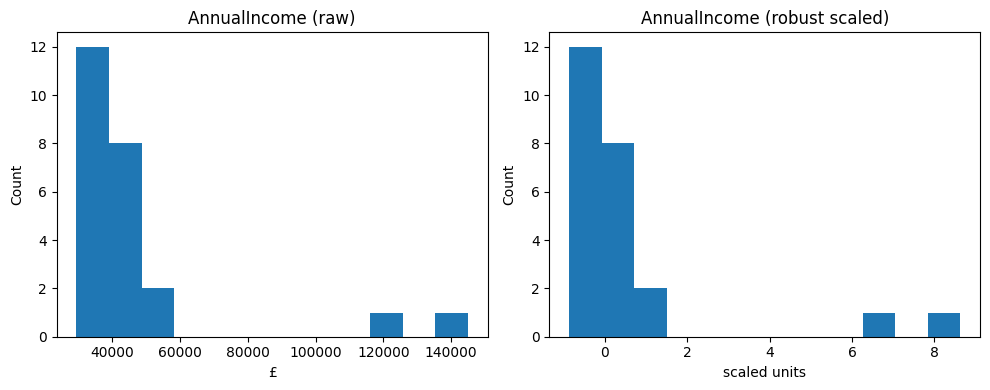

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df["AnnualIncome"], bins=12)
axes[0].set_title("AnnualIncome (raw)")
axes[0].set_xlabel("£")
axes[0].set_ylabel("Count")

axes[1].hist(df_robust["AnnualIncome_robust"], bins=12)
axes[1].set_title("AnnualIncome (robust scaled)")
axes[1].set_xlabel("scaled units")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# Discretisation and binning

Discretisation converts continuous variables into a finite set of categories.  
Binning is a specific discretisation technique that splits values into bins by equal width, equal frequency, or by domain rules. 

## Equal-width binning

Split the range into intervals of equal size. Works best when the distribution is not highly skewed. 


In [7]:
# Equal-width bins on BasketValue
bins = 4

df["Basket_eqwidth"] = pd.cut(df["BasketValue"], bins=bins)
df[["BasketValue", "Basket_eqwidth"]].head(10)


,BasketValue,Basket_eqwidth
0,82.200,"(48.229, 141.45]"
1,64.000,"(48.229, 141.45]"
2,64.400,"(48.229, 141.45]"
3,101.300,"(48.229, 141.45]"
4,103.600,"(48.229, 141.45]"
5,420.000,"(327.15, 420.0]"
6,68.400,"(48.229, 141.45]"
7,90.800,"(48.229, 141.45]"
8,87.900,"(48.229, 141.45]"
9,90.500,"(48.229, 141.45]"


## Equal-frequency binning

Create bins so that each bin has roughly the same number of observations. Useful for skewed data. 


In [8]:
# Equal-frequency (quantile) bins on AnnualIncome
q = 4  # quartiles

df["Income_eqfreq"] = pd.qcut(df["AnnualIncome"], q=q)
df[["AnnualIncome", "Income_eqfreq"]].head(10)


,AnnualIncome,Income_eqfreq
0,38594,"(34292.75, 39941.5]"
1,48145,"(46465.75, 145000.0]"
2,120000,"(46465.75, 145000.0]"
3,30266,"(29369.999, 34292.75]"
4,41319,"(39941.5, 46465.75]"
5,29370,"(29369.999, 34292.75]"
6,45906,"(39941.5, 46465.75]"
7,37551,"(34292.75, 39941.5]"
8,36336,"(34292.75, 39941.5]"
9,31872,"(29369.999, 34292.75]"


## Domain-driven binning

Use boundaries that carry meaning in the business context.  
Example: map `BasketValue` into spend tiers. 


In [9]:
# Domain-driven bins for BasketValue
# Example tiers: Low < $60, Medium $60–$120, High $120–$250, VIP ≥ $250
edges = [float("-inf"), 60, 120, 250, float("inf")]
labels = ["Low", "Medium", "High", "VIP"]

df["Basket_domain"] = pd.cut(df["BasketValue"], bins=edges, labels=labels)
df[["BasketValue", "Basket_domain"]].head(10)

,BasketValue,Basket_domain
0,82.200,Medium
1,64.000,Medium
2,64.400,Medium
3,101.300,Medium
4,103.600,Medium
5,420.000,VIP
6,68.400,Medium
7,90.800,Medium
8,87.900,Medium
9,90.500,Medium


## Quick comparison of binning methods

We compare counts per bin and simple summary stats to see differences that could influence downstream steps. 


In [11]:
# Helper: frequency tables
eqwidth_counts = df["Basket_eqwidth"].value_counts().sort_index()
eqfreq_counts  = df["Income_eqfreq"].value_counts().sort_index()
domain_counts  = df["Basket_domain"].value_counts().sort_index()

summary = pd.DataFrame({
    "Basket_eqwidth_counts": eqwidth_counts,
}).join(pd.DataFrame({"Income_eqfreq_counts": eqfreq_counts}), how="outer") \
 .join(pd.DataFrame({"Basket_domain_counts": domain_counts}), how="outer")

summary.fillna(0).astype(int)

,Basket_eqwidth_counts,Income_eqfreq_counts,Basket_domain_counts
"(48.229, 141.45]",23,0,0
"(141.45, 234.3]",0,0,0
"(234.3, 327.15]",0,0,0
"(327.15, 420.0]",1,0,0
"(29369.999, 34292.75]",0,6,0
"(34292.75, 39941.5]",0,6,0
"(39941.5, 46465.75]",0,6,0
"(46465.75, 145000.0]",0,6,0
High,0,0,1
Low,0,0,1


## Effect of binning on downstream analysis

Principles from the slides:

- Too few bins can merge dissimilar values and hide useful patterns. This can reduce model accuracy and produce coarse dashboards.  
- Too many bins can introduce unnecessary complexity. A model may overfit and reports may become harder to read.  
- Choose a sensible number of bins for the goal. Decision trees, for instance, can work directly with continuous variables, but carefully binned features can improve interpretability for business users. 


In [18]:
import pandas as pd 

# Simple demonstration: predict "High spender" using a threshold on BasketValue
# Then compare how a naive rule based on binned tiers performs versus the raw value.

# Ground truth: high spenders are baskets >= $120
df["HighSpender"] = (df["BasketValue"] >= 120).astype(int)

# Prediction from domain-driven bins: High or VIP => 1, else 0
pred_binned = df["Basket_domain"].isin(["High", "VIP"]).fillna(False).astype(int)

# Confusion matrix with readable labels
confusion = pd.crosstab(
    df["HighSpender"].map({0: "Actual: Not High", 1: "Actual: High"}),
    pd.Series(pred_binned).map({0: "Pred: Not High", 1: "Pred: High"}),
    rownames=[""], colnames=[""]
)

print("Confusion Matrix:\n")
print(confusion)


Confusion Matrix:

                  Pred: High  Pred: Not High
                                            
Actual: High               2               0
Actual: Not High           0              22


In [13]:
# Optional: keep the prepared features together for downstream work
prepared = pd.concat([df[["CustomerID", "Age", "AnnualIncome", "BasketValue",
                          "Basket_eqwidth", "Income_eqfreq", "Basket_domain", "HighSpender"]],
                      df_minmax.add_suffix(""), df_std.add_suffix(""), df_robust.add_suffix("")],
                     axis=1)

prepared.head()


,CustomerID,Age,AnnualIncome,BasketValue,Basket_eqwidth,Income_eqfreq,Basket_domain,HighSpender,Age_minmax,AnnualIncome_minmax,BasketValue_minmax,Age_std,AnnualIncome_std,BasketValue_std,Age_robust,AnnualIncome_robust,BasketValue_robust
0,1,23,38594,82.200,"(48.229, 141.45]","(34292.75, 39941.5]",Medium,0,0.000,0.080,0.090,-1.581,-0.320,-0.254,-0.989,-0.111,-0.239
1,2,58,48145,64.000,"(48.229, 141.45]","(46465.75, 145000.0]",Medium,0,0.778,0.162,0.041,0.874,0.036,-0.518,0.584,0.674,-0.859
2,3,52,120000,64.400,"(48.229, 141.45]","(46465.75, 145000.0]",Medium,0,0.644,0.784,0.043,0.453,2.713,-0.512,0.315,6.577,-0.846
3,4,41,30266,101.300,"(48.229, 141.45]","(29369.999, 34292.75]",Medium,0,0.400,0.008,0.142,-0.319,-0.630,0.023,-0.180,-0.795,0.413
4,5,41,41319,103.600,"(48.229, 141.45]","(39941.5, 46465.75]",Medium,0,0.400,0.103,0.148,-0.319,-0.218,0.056,-0.180,0.113,0.491


### What you should notice

- The domain-driven rule is easy to explain and will often be close to the raw-value rule since the bins align with the threshold.  
- If you used equal-width or equal-frequency bins that do not match business logic, the rule may be less interpretable or less accurate.  
- For modelling, try both approaches and evaluate with proper metrics and cross-validation. 


# Putting it together: recommended workflow

1. Inspect ranges and distributions.  
2. Choose a scaling method:
   - Min–Max when you need values in [0, 1].
   - Standardisation for algorithms that benefit from zero mean and unit variance.
   - Robust scaling when outliers are present.
3. If categories are useful for people or models, discretise:
   - Equal-width for simple ranges.
   - Equal-frequency for skewed data.
   - Domain-driven when clear business thresholds exist.
4. Check the effect on analysis:
   - Compare frequency tables, simple rules, and model metrics.
   - Prefer the simplest option that achieves the goal. 


## Key takeaways

- Scaling aligns feature magnitudes to make analyses fair and stable.  
- Normalisation maps values to [0, 1].  
- Standardisation centres at 0 with unit variance.  
- Robust scaling uses the median and IQR to reduce outlier influence.  
- Discretisation converts continuous variables into bins. Choose equal-width, equal-frequency, or domain-driven based on the distribution and business needs. 
